# Orientation activity map construction visualizations
It is not easy to understand orientation activity maps. But the key insight is that we sort neurons by preferred orientations, and then average the activity of neurons sharing preferred orientations.

## Imports

In [2]:
%cd ../../
%load_ext autoreload
%autoreload 2

/workspace/mahajnal/science/projects/csnl/analysis/wigner,theory/task-priors


In [3]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize
from tqdm import tqdm

from src.data_access import (
load_tables, 
retrieve_experiment_ids, 
retrieve_recording_day_experiment_ids, 
construct_testing_trial_bank, 
construct_multi_day_trial_bank,
retrieve_admissible_neurons, 
)

from src.orientation_representation import (
load_all_experiments_into_memory,
enforce_spike_trace_length,
construct_orientation_representation,
)

In [4]:
results_path = './results/random_visualizations'
production_path = './results/iclr_figures_bpteam'

## Load data

In [5]:
tables = load_tables()
df_celltable, df_trialtable = tables
experiment_ids = retrieve_experiment_ids(tables)

/workspace/mahajnal/science/projects/csnl/analysis/wigner,theory/task-priors/src/data_access.py:37: DtypeWarning: Columns (6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_celltable = pd.read_csv(DATASET['CellTable_path'])


In [6]:
trial_length = 100

## Compilation functions

In [19]:
def construct_neuron_matrix(admissible_neurons, experiment_data, trial_length, tqdm_disable=True, seed=None):
    """
    Construct a matrix where each row is the average trial activity of a single neuron
    across its relevant trials. No grouping by preferred orientation. Rows are shuffled.

    Parameters:
        admissible_neurons (DataFrame): Table with 'Experiment' and 'Cell' columns.
        experiment_data (dict): {experiment_id: {trial_id: np.array(time, cells)}}.
        trial_length (int): Number of time points per trial.
        tqdm_disable (bool): Whether to disable progress bar.
        seed (int or None): Random seed for reproducibility (default: None).

    Returns:
        neuron_matrix (ndarray): Shape (num_neurons, trial_length), rows shuffled.
    """
    neuron_matrix = []

    for row in tqdm(admissible_neurons.itertuples(), disable=tqdm_disable):
        experiment_id = row.Experiment
        cell_index = row.Cell - 1
        cell_spike_trace = np.zeros(trial_length)
        trial_count = len(experiment_data[experiment_id])

        if trial_count == 0:
            continue

        for trial_id in experiment_data[experiment_id]:
            spike_trace = experiment_data[experiment_id][trial_id][:, cell_index]
            spike_trace = enforce_spike_trace_length(spike_trace, trial_length)
            cell_spike_trace += spike_trace

        cell_spike_trace /= trial_count
        cell_spike_trace -= np.mean(cell_spike_trace[:23])  # Baseline subtraction
        neuron_matrix.append(cell_spike_trace)

    neuron_matrix = np.array(neuron_matrix)

    # Set random seed for reproducibility and shuffle rows
    if seed is not None:
        rng = np.random.default_rng(seed)
        rng.shuffle(neuron_matrix, axis=0)
    else:
        np.random.shuffle(neuron_matrix)

    return neuron_matrix


def construct_sorted_neuron_matrix(admissible_neurons, experiment_data, trial_length, tqdm_disable=True):
    """
    Constructs a neuron-by-time matrix where each row is a unique neuron's activity averaged across trials,
    and rows are sorted by preferred orientation.

    Parameters:
        admissible_neurons (pd.DataFrame): DataFrame containing neuron metadata including 'Experiment', 'Cell', and 'Pref_Orientation_spikes_2'.
        experiment_data (dict): Dictionary mapping experiment IDs to trial data (trial_id -> [time x neuron] arrays).
        trial_length (int): The expected length of the spike trace.
        tqdm_disable (bool): Whether to disable progress bar.

    Returns:
        sorted_matrix (np.ndarray): Neuron-by-time matrix sorted by preferred orientation.
    """
    neuron_traces = []
    orientations = []

    for row in tqdm(admissible_neurons.itertuples(), disable=tqdm_disable):
        experiment_id = row.Experiment
        cell_index = row.Cell - 1
        orientation = row.Pref_Orientation_spikes_2

        spike_accumulator = np.zeros(trial_length)
        trial_count = 0

        for trial_id in experiment_data[experiment_id]:
            spike_trace = experiment_data[experiment_id][trial_id][:, cell_index]
            spike_trace = enforce_spike_trace_length(spike_trace, trial_length)
            spike_accumulator += spike_trace
            trial_count += 1

        if trial_count > 0:
            average_trace = spike_accumulator / trial_count
            average_trace -= np.mean(average_trace[:23])  # Baseline subtraction
            neuron_traces.append(average_trace)
            orientations.append(orientation)

    # Convert to array and sort by orientation
    neuron_traces = np.array(neuron_traces)
    orientations = np.array(orientations)
    sort_indices = np.argsort(orientations)
    sorted_matrix = neuron_traces[sort_indices]

    return sorted_matrix


def plot_neuron_matrix_heatmap(neuron_matrix, title=None, xlabel='Time (frames)', ylabel='Neuron index', cmap='viridis', vmin=None, vmax=None, save_path=None):
    """
    Plots a heatmap of neuron-by-time activity.

    Parameters:
        neuron_matrix (ndarray): Array of shape (num_neurons, time).
        title (str): Title of the plot (default: None).
        xlabel (str): Label for the x-axis (default: 'Time (frames)').
        ylabel (str): Label for the y-axis (default: 'Neuron index').
        cmap (str): Colormap for heatmap (default: 'viridis').
        vmin, vmax (float): Value range for color scaling (optional).
        save_path (str): Path to save the figure (default: None).

    Returns:
        None
    """
    plt.figure(figsize=(5, 6))
    im = plt.imshow(neuron_matrix, aspect='auto', cmap=cmap, interpolation='nearest', vmin=vmin, vmax=vmax)

    if title:
        plt.title(title, fontsize=14)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    cbar = plt.colorbar(im)
    cbar.set_label('APrE/trial')

    # Create tick positions and labels in seconds
    num_timepoints = neuron_matrix.shape[1]
    frame_rate = 15  # frames per second
    zero_index = 24  # index that corresponds to 0 s
    
    # Generate ticks every 0.5 seconds from -1.5s to max time
    min_sec = -1.5
    max_sec = (num_timepoints - zero_index) / frame_rate
    tick_secs = np.arange(min_sec, max_sec + 0.01, 1.0)
    
    # Convert to frame indices
    x_ticks = [int(zero_index + s * frame_rate) for s in tick_secs]
    x_labels = [f"{s:.1f}" for s in tick_secs]
    
    plt.xticks(ticks=x_ticks, labels=x_labels)
    plt.xlabel("Time (s)")

    plt.ylim(1,180)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()


def plot_orientation_representation(trial_matrix, title, save_fig=False, figsize=(5,6), endangle=360):
    plt.figure(figsize=figsize)
    plt.imshow(
        trial_matrix,
        aspect='auto',
        cmap='viridis',
        interpolation='nearest',
        vmin=-0.01,
        vmax=0.04,
        origin='lower'
    )

    plt.colorbar(label='APrE/trial')
    plt.title(title,fontsize='medium')
    plt.xlabel('Time Steps',fontsize='medium')
    plt.ylabel('Preferred orientations',fontsize='medium')
    
    # Set the y-axis ticks and labels
    y_ticks = np.arange(29, 360, 30)  # Ticks starting from 30 to 360 with steps of 30
    plt.yticks(y_ticks, y_ticks + 1)  # Adding 1 to range because the index is zero-based
    plt.ylim(endangle,1)

    # Create tick positions and labels in seconds
    num_timepoints = trial_matrix.shape[1]
    frame_rate = 15  # frames per second
    zero_index = 24  # index that corresponds to 0 s
    
    # Generate ticks every 0.5 seconds from -1.5s to max time
    min_sec = -1
    max_sec = (num_timepoints - zero_index) / frame_rate
    tick_secs = np.arange(min_sec, max_sec + 0.01, 1.0)
    
    # Convert to frame indices
    x_ticks = [int(zero_index + s * frame_rate) for s in tick_secs]
    x_labels = [f"{s:.0f}" for s in tick_secs]
    
    plt.xticks(ticks=x_ticks, labels=x_labels)
    plt.xlabel("Time (s)", fontsize='medium')

    plt.tight_layout()

    if save_fig:
        plt.savefig(save_fig)
    plt.show()



def plot_orientation_representation_rotated(trial_matrix, title, save_fig=False, figsize=(5,6), endangle=360):
    plt.figure(figsize=figsize)
    plt.imshow(
        trial_matrix.T,
        aspect='auto',
        cmap='viridis',
        interpolation='nearest',
        vmin=-0.01,
        vmax=0.04,
        origin='lower'
    )

    plt.colorbar(label='APrE/trial')
    plt.title(title) #,fontsize=16)
    plt.ylabel('Time Steps') #,fontsize=16)
    plt.xlabel('Preferred orientations') #,fontsize=16)
    
    # Set the y-axis ticks and labels
    x_ticks = np.arange(29, 360, 30)  # Ticks starting from 30 to 360 with steps of 30
    plt.xticks(x_ticks, [str(x + 1) for x in x_ticks])  # Adding 1 to range and converting to string for labels
    plt.xlim(1,endangle)

    # Create tick positions and labels in seconds
    num_timepoints = trial_matrix.shape[1]
    frame_rate = 15  # frames per second
    zero_index = 24  # index that corresponds to 0 s
    
    # Generate ticks every 0.5 seconds from -1.5s to max time
    min_sec = -2.0
    max_sec = (num_timepoints - zero_index) / frame_rate
    tick_secs = np.arange(min_sec, max_sec + 0.01, 1.0)
    
    # Convert to frame indices
    y_ticks = [int(zero_index + s * frame_rate) for s in tick_secs]
    y_labels = [f"{s:.1f}" for s in tick_secs]
    
    plt.yticks(ticks=y_ticks, labels=y_labels)
    plt.ylim((y_ticks[0]+y_ticks[1])/2, (y_ticks[-1]+y_ticks[-2])/2)
    plt.ylabel("Time (s)")

    plt.tight_layout()

    if save_fig:
        plt.savefig(save_fig)
    plt.show()    

In [8]:
def construct_shuffled_activity_map(recording_day, visual_stimulus,):
    relevant_experiment_ids = retrieve_recording_day_experiment_ids(recording_day, tables)
    trial_bank = construct_testing_trial_bank(
        relevant_experiment_ids, 
        recording_day, 
        visual_stimulus, 
        tables
    )
    
    admissible_neurons = retrieve_admissible_neurons(relevant_experiment_ids, tables)
    experiment_data = load_all_experiments_into_memory(trial_bank, tqdm_disable=False)

    activity_map = construct_neuron_matrix(
        admissible_neurons, 
        experiment_data, 
        trial_length, 
        tqdm_disable=False,
        seed=420
    )
    return activity_map


def construct_sorted_activity_map(recording_day, visual_stimulus,):
    relevant_experiment_ids = retrieve_recording_day_experiment_ids(recording_day, tables)
    trial_bank = construct_testing_trial_bank(
        relevant_experiment_ids, 
        recording_day, 
        visual_stimulus, 
        tables
    )
    
    admissible_neurons = retrieve_admissible_neurons(relevant_experiment_ids, tables)
    experiment_data = load_all_experiments_into_memory(trial_bank, tqdm_disable=False)

    activity_map = construct_sorted_neuron_matrix(
        admissible_neurons, 
        experiment_data, 
        trial_length, 
        tqdm_disable=False,
    )
    return activity_map

def construct_activity_map(recording_day, visual_stimulus,):
    relevant_experiment_ids = retrieve_recording_day_experiment_ids(recording_day, tables)
    trial_bank = construct_testing_trial_bank(
        relevant_experiment_ids, 
        recording_day, 
        visual_stimulus, 
        tables
    )
    
    admissible_neurons = retrieve_admissible_neurons(relevant_experiment_ids, tables)
    experiment_data = load_all_experiments_into_memory(trial_bank, tqdm_disable=False)

    activity_map = construct_orientation_representation(
        admissible_neurons, 
        experiment_data, 
        trial_length, 
        tqdm_disable=False,
    )
    return activity_map

## Construct activity map

In [8]:
neuron_matrix_shuffled = construct_shuffled_activity_map('D1', 45, )

100%|███████████████████████████████████████████| 10/10 [00:42<00:00,  4.21s/it]
2007it [00:01, 1101.06it/s]


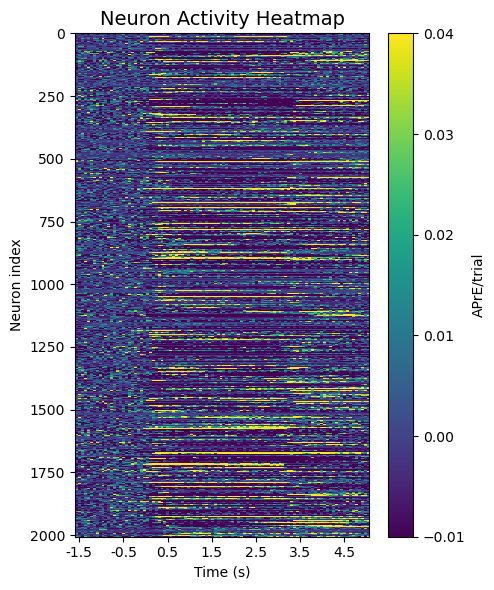

In [9]:
plot_neuron_matrix_heatmap(
    neuron_matrix_shuffled, title='Neuron Activity Heatmap', 
    vmin=-0.01, vmax=0.04,
    save_path=os.path.join(results_path, 'shuffled_neuron_activity_map.png'),
)

In [9]:
neuron_matrix_sorted = construct_sorted_activity_map('D1', 45, )

100%|██████████| 10/10 [00:45<00:00,  4.55s/it]
2007it [00:00, 6045.82it/s]


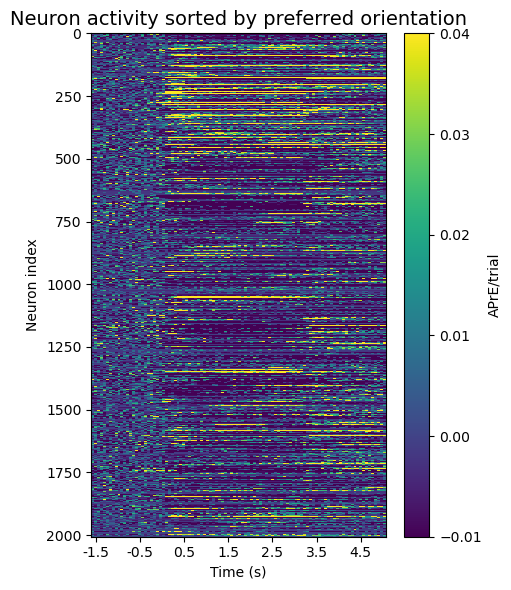

In [11]:
plot_neuron_matrix_heatmap(
    neuron_matrix_sorted, title='Neuron activity sorted by preferred orientation', 
    vmin=-0.01, vmax=0.04,
    save_path=os.path.join(results_path, 'sorted_neuron_activity_map.png'),
)

In [9]:
activity_map = construct_activity_map('D1', 45, )

100%|██████████| 10/10 [00:43<00:00,  4.34s/it]
2007it [00:00, 6102.73it/s]


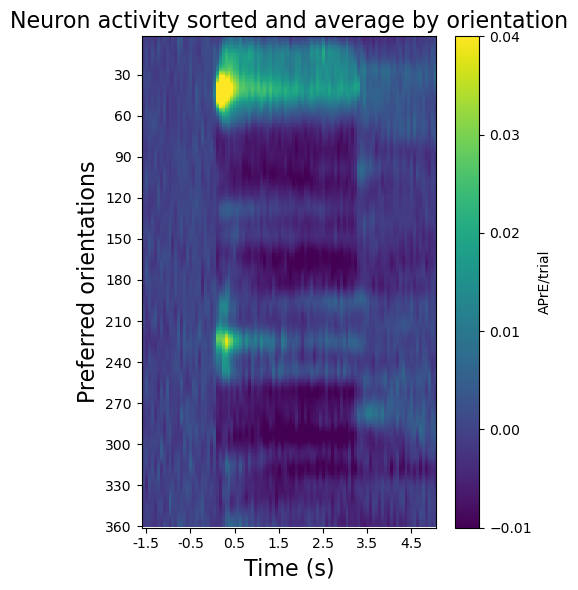

In [58]:
plot_orientation_representation(
    activity_map, 
    'Neuron activity sorted and average by orientation', 
    save_fig=os.path.join(results_path, 'sorted_averaged_neuron_activity_map.png'),
    endangle=360
)

## Panel for cosyne

In [14]:
def plot_orientation_activity_composite_aligned(
    activity_map, 
    stimulus_activity=(40, 60), 
    endangle=180, 
    figsize=(5, 6), save_fig=False
):
    # Extract time-averaged profile
    activity_profile_mean = np.nanmean(
        activity_map[:, stimulus_activity[0]:stimulus_activity[1]], axis=-1
    )
    activity_profile_std = np.nanstd(
        activity_map[:, stimulus_activity[0]:stimulus_activity[1]], axis=-1
    )

    # Orientation axis
    x = np.arange(1, endangle + 1)
    y = activity_profile_mean[:endangle]

    # Set up figure with separate cax for colorbar
    fig = plt.figure(figsize=figsize)
    gs = GridSpec(2, 2, width_ratios=[20, 1], height_ratios=[1, 1], hspace=0.05, wspace=0.05)

    # Top: Activity profile
    ax0 = fig.add_subplot(gs[0, 0])
    cmap = plt.get_cmap('viridis')
    ax0.fill_between(
        x,
        y - activity_profile_std[:endangle],
        y + activity_profile_std[:endangle],
        alpha=0.3,
        color=cmap(0.5)
    )
    
    # Create segments from x and y
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    # Normalize y-values to the colormap
    norm = Normalize(vmin=-0.01, vmax=0.04)
    lc = LineCollection(segments, cmap=cmap, norm=norm, linewidth=4)
    lc.set_array(y)
    
    # Add to axis
    line = ax0.add_collection(lc)
    
    ax0.set_ylabel("Population activity", fontsize=12)
    ax0.set_xticks([])
    ax0.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax0.set_yticks([-0.01, 0.00, 0.01, 0.02, 0.03])
    ax0.spines['top'].set_visible(False)
    ax0.spines['right'].set_visible(False)

    # Bottom left: Activity map
    ax1 = fig.add_subplot(gs[1, 0], sharex=ax0)
    im = ax1.imshow(
        activity_map[:endangle].T,
        aspect='auto',
        cmap='viridis',
        interpolation='nearest',
        vmin=-0.01,
        vmax=0.04,
        origin='lower'
    )

    # Bottom right: Colorbar
    cax = fig.add_subplot(gs[1, 1])
    cbar = fig.colorbar(im, cax=cax)
    cbar.set_label('APrE / trial')

    # Axis labeling
    ax1.set_ylabel("Time (s)", fontsize=12)
    ax1.set_xlabel("Preferred orientation (°)", fontsize=12)
    ax1.set_xticks(np.arange(30, endangle + 1, 30))
    ax1.set_xticklabels(np.arange(30, endangle + 1, 30))

    # Time ticks
    num_timepoints = activity_map.shape[1]
    frame_rate = 15
    zero_index = 24
    min_sec = -1.5
    max_sec = (num_timepoints - zero_index) / frame_rate
    tick_secs = np.arange(min_sec, max_sec + 0.01, 1.0)
    y_ticks = [int(zero_index + s * frame_rate) for s in tick_secs]
    y_labels = [f"{s:.1f}" for s in tick_secs]
    ax1.set_yticks(y_ticks)
    ax1.set_yticklabels(y_labels)

    if save_fig:
        plt.savefig(save_fig, bbox_inches='tight')

    plt.show()

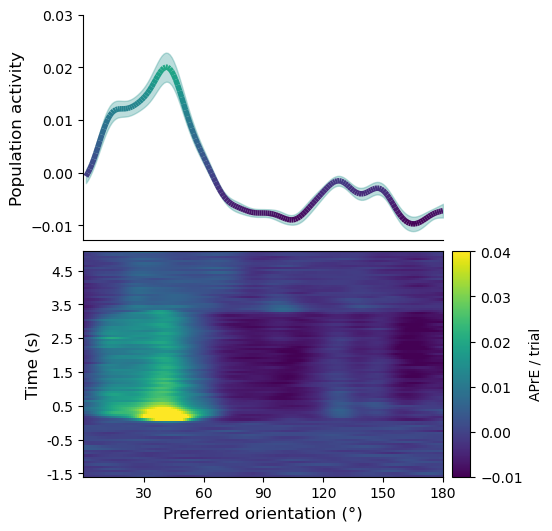

In [15]:
plot_orientation_activity_composite_aligned(activity_map, 
                                            endangle=180,
                                            save_fig=os.path.join(results_path, 
                                                                  'activity_profile_map.pdf'),
                                           )

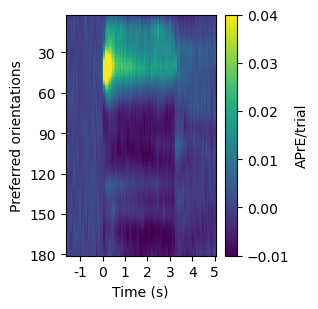

In [ ]:
plot_orientation_representation(
    activity_map, 
    None,
    save_fig=os.path.join(production_path, 'sorted_averaged_neuron_activity_map.png'),
    # save_fig=os.path.join(production_path,'mouse-pdf', 'Fig1C_sorted_averaged_neuron_activity_map.pdf'),
    figsize=(3.2,3.2),
    endangle=180
)

new render: 0-180, larger fonts

rotated perpendicular file

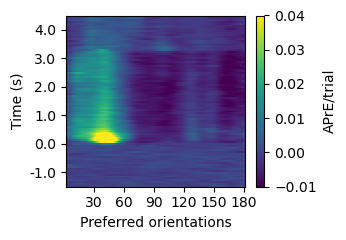

In [10]:
plot_orientation_representation_rotated(
    activity_map, 
    None,
    save_fig=os.path.join(production_path, 'sorted_averaged_neuron_activity_map_rotated.png'),
    # save_fig=os.path.join(production_path,'mouse-pdf', 'Fig1C_sorted_averaged_neuron_activity_map_rotated.pdf'),
    figsize=(3.5,2.5),
    endangle=180
)